In [ ]:
from feature_engineering.transformation import LogTransformer, PowerTransformerWrapper, QuantileTransformerWrapper, CustomTransformer, diagnostic_plots, suggest_transformation
from utils import ForexPreprocessor

timeframe = 60
processor = ForexPreprocessor(timeframe)
data = processor.load_and_preprocess(f'data/GBPUSD/GBPUSD_{timeframe}.csv')

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(['target', 'future_change'], axis=1), 
    data['target'], 
    test_size=0.3, 
    random_state=42
)

transform_cols = ['volume_ratio', 'volatility']

log_transformer = LogTransformer(cols=transform_cols)
X_train_log = log_transformer.fit_transform(X_train)
print("Log transformation applied to:", [col for col in X_train_log.columns if '_log' in col])

power_transformer = PowerTransformerWrapper(cols=transform_cols, method='box-cox')
X_train_power = power_transformer.fit_transform(X_train[X_train[transform_cols].min(axis=1) > 0])
print("Box-Cox transformation applied")

quantile_transformer = QuantileTransformerWrapper(cols=transform_cols, output_distribution='normal')
X_train_quantile = quantile_transformer.fit_transform(X_train)
print("Quantile transformation to normal distribution applied")

sqrt_transformer = CustomTransformer(cols=['volume_ratio'], transform_func=np.sqrt, func_name='sqrt')
X_train_sqrt = sqrt_transformer.fit_transform(X_train)
print("Custom square root transformation applied")

for col in transform_cols:
    if col in X_train.columns:
        suggestions = suggest_transformation(X_train, col)
        print(f"\nTransformation suggestions for {col}:")
        print(f"Skewness: {suggestions['skewness']:.3f}")
        print(f"Suggestions: {suggestions['suggestions']}")

diagnostic_plots(X_train_log, 'volume_ratio_log')

## Old

In [1]:
import pandas as pd
import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

from feature_engineering import transformation
# plt.style.use('seaborn-colorblind')
# %matplotlib inline
#from feature_cleaning import rare_values as ra

## Load Dataset

In [2]:
use_cols = [
    'Pclass', 'Sex', 'Age', 'Fare', 'SibSp',
    'Survived'
]

data = pd.read_csv('./data/titanic.csv', usecols=use_cols)


In [3]:
data.head(3)

,Survived,Pclass,Sex,Age,SibSp,Fare
0,0,3,male,22.0,1,7.2500
1,1,1,female,38.0,1,71.2833
2,1,3,female,26.0,0,7.9250


In [4]:
# Note that we include target variable in the X_train 
# because we need it to supervise our discretization
# this is not the standard way of using train-test-split
X_train, X_test, y_train, y_test = train_test_split(data, data.Survived, test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((623, 6), (268, 6))

## Logarithmic transformation

Variable Fare Q-Q plot


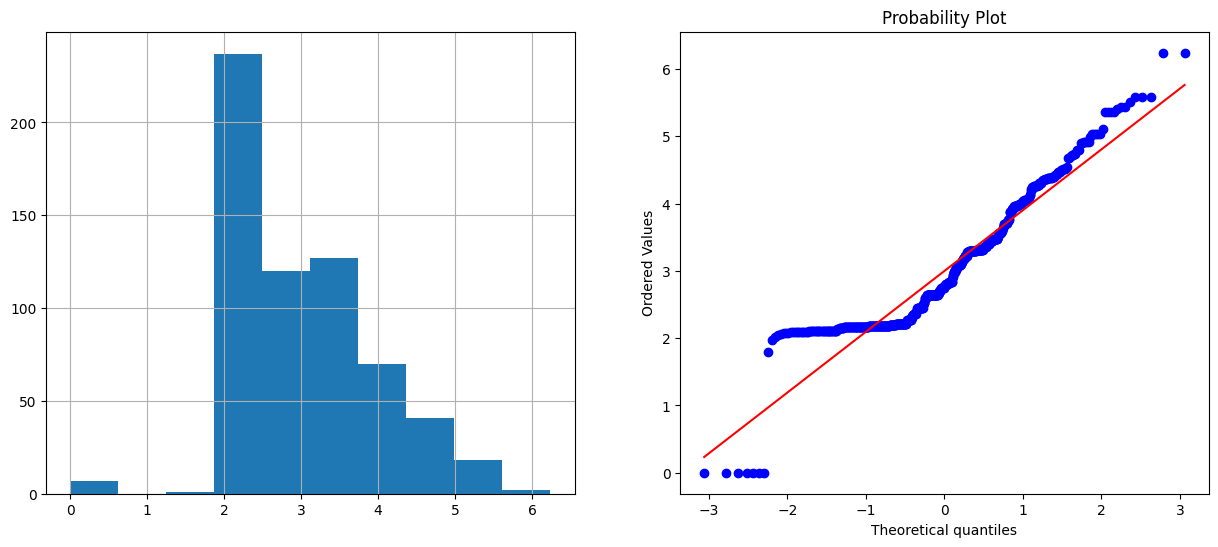

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_log
857         1       1    male  51.0      0  26.5500  3.316003
52          1       1  female  49.0      1  76.7292  4.353231
386         0       3    male   1.0      5  46.9000  3.869116
124         0       1    male  54.0      0  77.2875  4.360388
578         0       3  female   NaN      1  14.4583  2.738146
549         1       2    male   8.0      1  36.7500  3.630985


In [5]:
# add the new created feature
X_train_copy = X_train.copy(deep=True)
X_train_copy = transformation.log_transform(data=X_train,cols=['Fare'])
print(X_train_copy.head(6))

## Reciprocal transformation

Variable Fare Q-Q plot


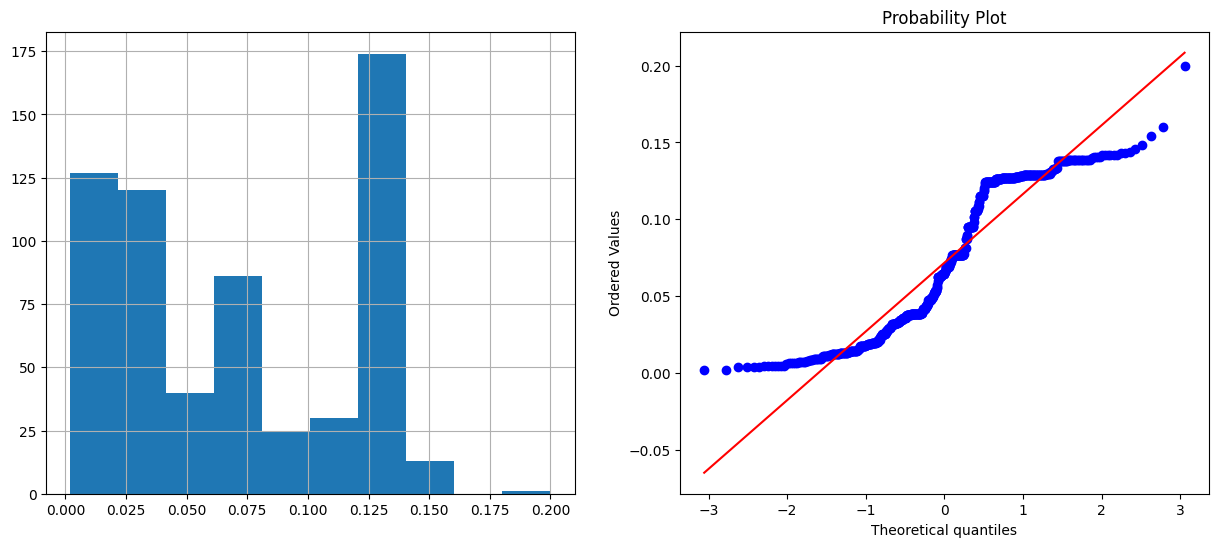

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_reciprocal
857         1       1    male  51.0      0  26.5500         0.037665
52          1       1  female  49.0      1  76.7292         0.013033
386         0       3    male   1.0      5  46.9000         0.021322
124         0       1    male  54.0      0  77.2875         0.012939
578         0       3  female   NaN      1  14.4583         0.069164
549         1       2    male   8.0      1  36.7500         0.027211


In [6]:
# add the new created feature
X_train_copy = X_train.copy(deep=True)
X_train_copy = X_train_copy[X_train_copy.Fare!=0] # Warning that x should not be 0
#X_train_copy[X_train_copy.Fare==0]
X_train_copy = transformation.reciprocal_transform(data=X_train_copy,cols=['Fare'])
print(X_train_copy.head(6))

## Square root transformation

Variable Fare Q-Q plot


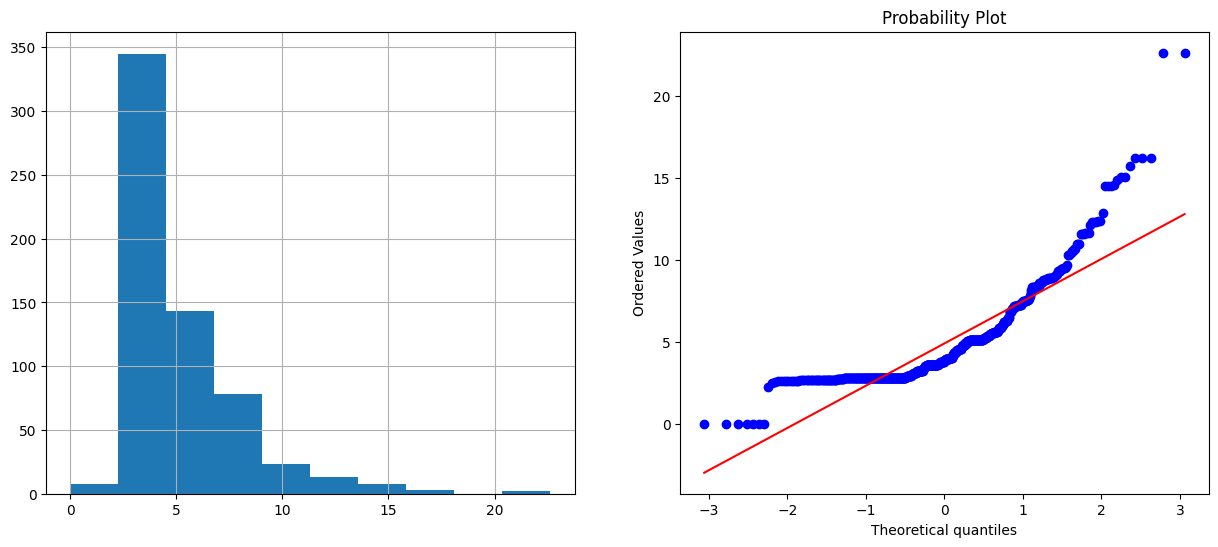

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_square_root
857         1       1    male  51.0      0  26.5500          5.152669
52          1       1  female  49.0      1  76.7292          8.759521
386         0       3    male   1.0      5  46.9000          6.848357
124         0       1    male  54.0      0  77.2875          8.791331
578         0       3  female   NaN      1  14.4583          3.802407
549         1       2    male   8.0      1  36.7500          6.062178


In [7]:
# add the new created feature
X_train_copy = X_train.copy(deep=True)
X_train_copy = transformation.square_root_transform(data=X_train,cols=['Fare'])
print(X_train_copy.head(6))

## Exponential transformation

Variable Fare Q-Q plot


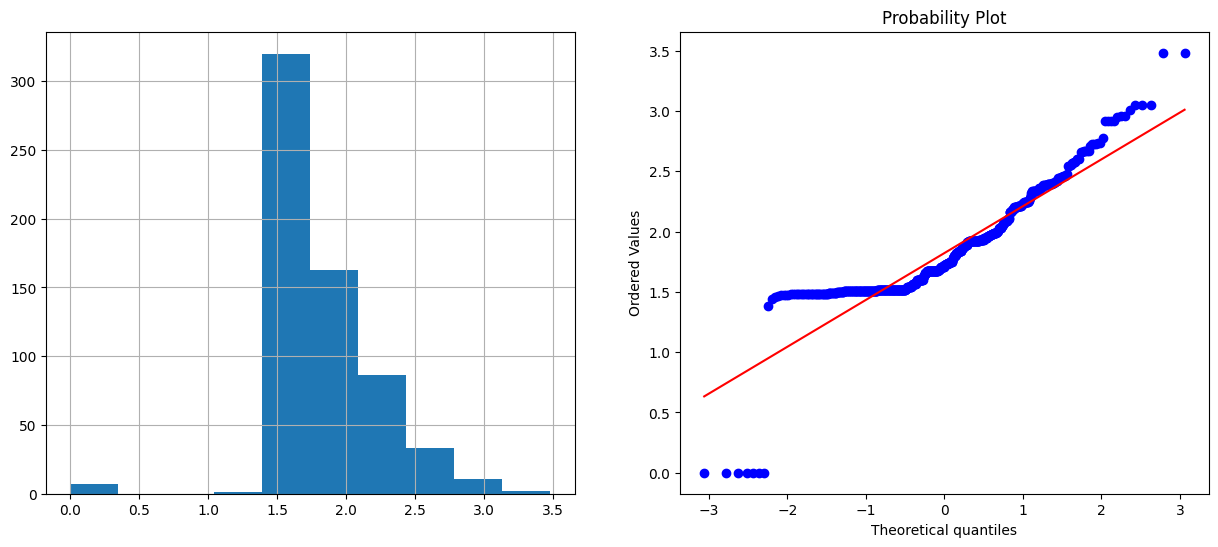

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_exp
857         1       1    male  51.0      0  26.5500  1.926695
52          1       1  female  49.0      1  76.7292  2.382276
386         0       3    male   1.0      5  46.9000  2.158910
124         0       1    male  54.0      0  77.2875  2.385733
578         0       3  female   NaN      1  14.4583  1.706174
549         1       2    male   8.0      1  36.7500  2.056134


In [8]:
# add the new created feature
X_train_copy = X_train.copy(deep=True)
X_train_copy = transformation.exp_transform(data=X_train,cols=['Fare'],coef=0.2)
print(X_train_copy.head(6))

## Box-cox transformation

In [9]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer().fit(X_train[['Fare']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_boxcox'] = pt.transform(X_train_copy[['Fare']])
print(X_train_copy.head(6))

     Survived  Pclass     Sex   Age  SibSp     Fare  Fare_boxcox
857         1       1    male  51.0      0  26.5500     0.398696
52          1       1  female  49.0      1  76.7292     1.401774
386         0       3    male   1.0      5  46.9000     0.950718
124         0       1    male  54.0      0  77.2875     1.408228
578         0       3  female   NaN      1  14.4583    -0.222897
549         1       2    male   8.0      1  36.7500     0.718007


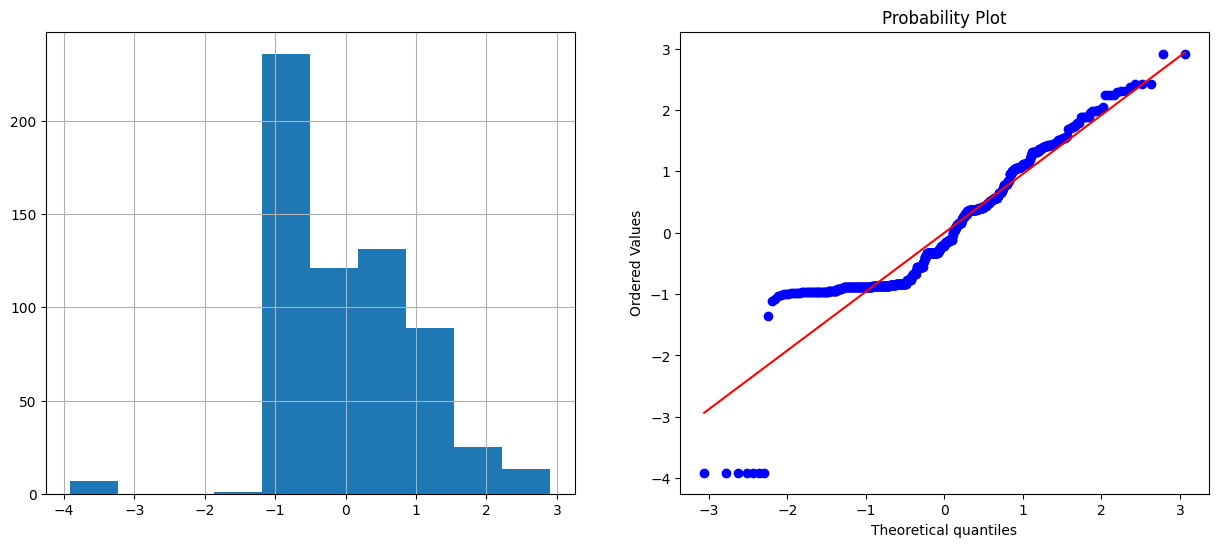

In [10]:
transformation.diagnostic_plots(X_train_copy,'Fare_boxcox')

## Quantile transformation

In [11]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal').fit(X_train[['Fare']])
X_train_copy = X_train.copy(deep=True)
X_train_copy['Fare_qt'] = qt.transform(X_train_copy[['Fare']])
print(X_train_copy.head(6))

     Survived  Pclass     Sex   Age  SibSp     Fare   Fare_qt
857         1       1    male  51.0      0  26.5500  0.470128
52          1       1  female  49.0      1  76.7292  1.269732
386         0       3    male   1.0      5  46.9000  0.841047
124         0       1    male  54.0      0  77.2875  1.287991
578         0       3  female   NaN      1  14.4583 -0.022167
549         1       2    male   8.0      1  36.7500  0.744471


/home/hung/.local/share/virtualenvs/stock_investing-PNNd6zCB/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:2663: UserWarning: n_quantiles (1000) is greater than the total number of samples (623). n_quantiles is set to n_samples.
  warnings.warn(


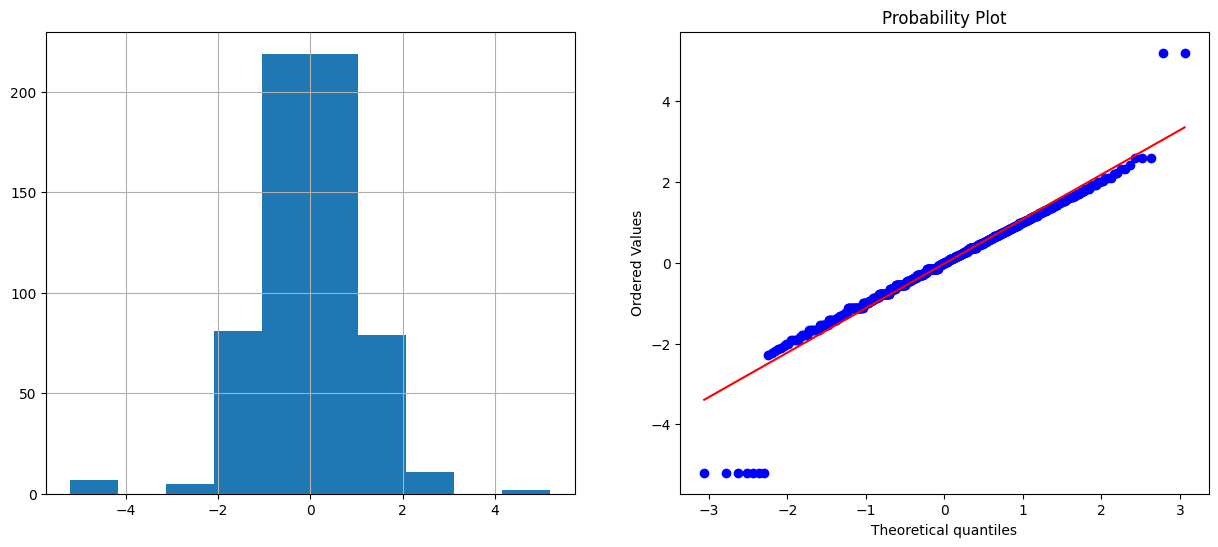

In [12]:
transformation.diagnostic_plots(X_train_copy,'Fare_qt')